<a href="https://colab.research.google.com/github/czarodziejszyn/ssne/blob/main/projekt2/predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import torch
import torch.nn as nn
import pandas as pd
import torch.utils.data as data
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import matplotlib.pyplot as plt

In [51]:
class PredictorBN(nn.Module):
    def __init__(self):
        super(PredictorBN, self).__init__()
        self.lin1 =nn.Linear(23, 142)
        self.bn1 = nn.BatchNorm1d(142)
        self.act1 =nn.ReLU()
        self.lin2 =nn.Linear(142, 71)
        self.bn2 = nn.BatchNorm1d(71)
        self.act2 =nn.ReLU()
        self.lin3 =nn.Linear(71, 1)


    def forward(self, x):
        x = self.lin1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.lin2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.lin3(x)
        return x

In [43]:
train_data = pd.read_csv('train_data.csv')

In [44]:
num_cols = ['SalePrice', 'YearBuilt', 'Size(sqf)', 'Floor',
            'N_Parkinglot(Ground)', 'N_Parkinglot(Basement)', 'N_manager',
            'N_elevators', 'N_FacilitiesNearBy(Total)', 'N_SchoolNearBy(Total)']
cat_cols = ['HallwayType', 'HeatingType', 'AptManageType', 'TimeToBusStop',
            'TimeToSubway', 'SubwayStation']

le = LabelEncoder()
train_data['TimeToBusStop'] = le.fit_transform(train_data['TimeToBusStop'])
train_data['TimeToSubway'] = le.fit_transform(train_data['TimeToSubway'])

ohe_cols = ['HallwayType', 'HeatingType', 'AptManageType', 'SubwayStation']
train_data = pd.get_dummies(train_data, columns=ohe_cols, drop_first=True).astype(float)

In [48]:
print(train_data.head())

   SalePrice  YearBuilt  Size(sqf)  Floor  N_Parkinglot(Ground)  \
0   141592.0     2006.0      814.0    3.0                 111.0   
1    51327.0     1985.0      587.0    8.0                  80.0   
2    48672.0     1985.0      587.0    6.0                  80.0   
3   380530.0     2006.0     2056.0    8.0                 249.0   
4    78318.0     1992.0      644.0    2.0                 142.0   

   N_Parkinglot(Basement)  TimeToBusStop  TimeToSubway  N_manager  \
0                   184.0            2.0           1.0        3.0   
1                    76.0            0.0           3.0        2.0   
2                    76.0            0.0           3.0        2.0   
3                   536.0            0.0           0.0        5.0   
4                    79.0            2.0           2.0        4.0   

   N_elevators  ...  HallwayType_terraced  HeatingType_individual_heating  \
0          0.0  ...                   1.0                             1.0   
1          2.0  ...         

In [58]:
train_dataset = data.TensorDataset(torch.tensor(train_data.drop('SalePrice', axis=1).values).float(),
                                   torch.tensor(train_data['SalePrice'].values).float())
data_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)

In [59]:
model = PredictorBN()
criterion = nn.MSELoss()
opt_bn = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch: 0, Loss: 62382145536.0
Epoch: 1, Loss: 48461639680.0
Epoch: 2, Loss: 46735220736.0
Epoch: 3, Loss: 55614857216.0
Epoch: 4, Loss: 61562126336.0
Epoch: 5, Loss: 37210136576.0
Epoch: 6, Loss: 46163546112.0
Epoch: 7, Loss: 68359540736.0
Epoch: 8, Loss: 65692917760.0
Epoch: 9, Loss: 48466931712.0
Epoch: 10, Loss: 59311947776.0
Epoch: 11, Loss: 40550457344.0
Epoch: 12, Loss: 47745601536.0
Epoch: 13, Loss: 57029758976.0
Epoch: 14, Loss: 50580148224.0
Epoch: 15, Loss: 32308574208.0
Epoch: 16, Loss: 37557583872.0
Epoch: 17, Loss: 48677482496.0
Epoch: 18, Loss: 49892712448.0
Epoch: 19, Loss: 50695081984.0
Epoch: 20, Loss: 56134971392.0
Epoch: 21, Loss: 45507641344.0
Epoch: 22, Loss: 33150019584.0
Epoch: 23, Loss: 71865532416.0
Epoch: 24, Loss: 53682532352.0
Epoch: 25, Loss: 48803717120.0
Epoch: 26, Loss: 39112323072.0
Epoch: 27, Loss: 33973944320.0
Epoch: 28, Loss: 41383202816.0
Epoch: 29, Loss: 51919835136.0
Epoch: 30, Loss: 46178922496.0
Epoch: 31, Loss: 46353747968.0
Epoch: 32, Loss: 4

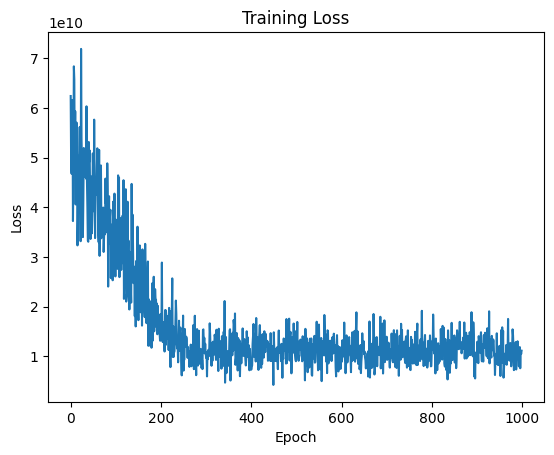

In [61]:
losses = []
for epoch in range(1000):
  for x, y in data_loader:
    opt_bn.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    opt_bn.step()
  losses.append(loss.item())
  print(f"Epoch: {epoch}, Loss: {loss.item()}")

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


In [ ]:
test_data = pd.read_csv('test_data.csv')